# Notebook for Demo of methods Used:

## This Notebook Content is:

1. Transforming the audio data to STFT(time-frequancy domain), and the inverse operation

2. DOS(Dominent Source), Masking, and SS(Source Separation) using masking directly

3. What is DC(Deep Clustering) and using it for SS or BSS(Blind Source Separation)

4. Using MC(Multi-Channel) input for BSS without DL(Deep Learning) and computing masks using those methods for unsupervised training of a DC model

### 1. Transforming the audio data to STFT(time-frequancy domain), and the inverse operation:

In [168]:
# imports
# scientific libreries
import numpy as np
import librosa
import soundfile as sf
import torch
from sklearn.cluster import KMeans

# utilities
import os
import joblib
from einops import rearrange

# for show
import IPython


In [169]:
def plot_mask(mask, *, ax=None):
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(
        mask,
        interpolation='nearest',
        vmin=0,
        vmax=1,
        origin='lower'
    )
    cbar = plt.colorbar(image, ax=ax)
    return ax

def plot_stft(stft_signal, *, ax=None):
    if ax is None:
        ax = plt.gca()
        
    stft_signal = np.abs(stft_signal)
        
    
    stft_signal = 10 * np.log10(
        np.maximum(stft_signal, np.max(stft_signal) / 1e6))
    # 1e6: 60 dB is sufficient
        
    image = ax.imshow(
        stft_signal,
        interpolation='nearest',
        origin='lower',
    )
    cbar = plt.colorbar(image, ax=ax)
    cbar.set_label('Energy / dB')
    return ax

In [120]:
# path to a directory containing the samples for this repo
# TODO: add link to github lfs, and get samples from there
demo_cache = "C:\\Users\\shaig\\Documents\\CS_Technion\\2019_b\\Deep Learning Project\\repos\\unsupervised_spatial_dc\\demo_cache"

In [110]:
# path to a sound file
audio_path = os.path.join(demo_cache, 'audio_sample.wav')

In [128]:
# reading .wav as float vectors
# reading single channel audio
audio_data, sr = sf.read(audio_path)
print(f'data array shape: {audio_data.shape}, \
        data type: {audio_data.dtype}, \
        sample rate: {sr}')
IPython.display.Audio(audio_data, rate=sr)

data array shape: (32000,),         data type: float64,         sample rate: 16000


In [134]:
# for displaing the waveform, and the stft:
from librosa.display import waveplot, specshow
from matplotlib import pyplot as plt

In [198]:
# time-frequancy domain representation
stft_params = {
    'n_fft': 512,
    'win_length': 512, 
    'hop_length': 128, 
}
def stft(signal):
    return librosa.stft(signal, **stft_params)

def istft(tfs):
    return librosa.istft(tfs,
                         win_length=stft_params['win_length'],
                         hop_length=stft_params['hop_length'])

In [180]:
X = stft(audio_data)
print(f'X shape: {X.shape}')

X shape: (257, 251)


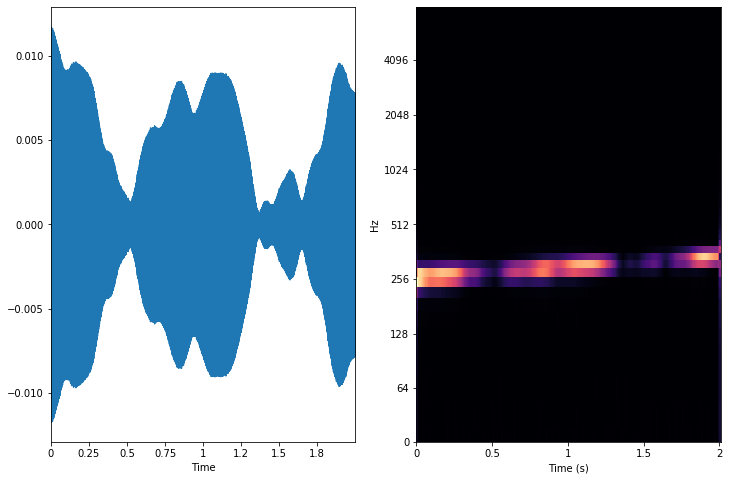

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
waveplot(audio_data, sr=sr, ax=axs[0])
specshow(np.abs(X), sr=sr, hop_length=stft_params['hop_length'],x_axis='s', y_axis='log', ax=axs[1])
plt.show()

In [189]:
# inverse operation on the original audio
reconstructed_audio_data = istft(X)
print(f'data array shape: {reconstructed_audio_data.shape}, \
        data type: {reconstructed_audio_data.dtype}')
IPython.display.Audio(reconstructed_audio_data, rate=sr)

data array shape: (32000,),         data type: float32


#### Summery:
The pourpuse of using stft is to get more information about the frequancies in the audio.
It is very popular in machine learning algorithems on audio data, 
mostly because the STFT algorithem is very efficient and gives as more detailed information about the signal input.

### 2. DOS(Dominent Source), Masking, and SS(Source Separation) using masking directly

#### What is Dominant Source?
This is just a method for seperating the signals, by assuming that each bin of the signal contains only one source.

This is of course not true, as some bins can be a combination of sources, and so the seperation that way will not be perfect.

by directly using the ground-truth mask we get the upper bound of the accuracy

In [193]:
# reading one of the pre-processed mixtures
props = [
    'imag_tfs',
    'real_tfs',
    'ground_truth_mask',
    'soft_labeled_mask',
    'wavs',
]
data_dict = {}
for prop in props:
    data_dict[prop] = joblib.load(os.path.join(demo_cache, prop))

data_dict['stft'] = data_dict['imag_tfs']*1j + data_dict['real_tfs']
data_dict

{'imag_tfs': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.2196468e-15,  2.8301992e+01, -9.8180981e+00, ...,
         -2.8528585e+00,  3.0310736e+00,  2.6527185e+00],
        [ 1.2461946e-15, -3.0210741e+01,  2.5309134e+01, ...,
          3.2503097e+00, -4.0002099e-01, -1.4373436e+00],
        ...,
        [-1.0241500e-15, -1.1289849e-02, -1.1536563e-03, ...,
          1.1409733e-03, -7.7256840e-04,  8.1324950e-03],
        [ 6.6613381e-16,  3.8681477e-01,  4.7800737e-03, ...,
         -7.0180243e-04,  2.6357663e-04, -1.6461714e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32),
 'real_tfs': array([[-5.57739372e+01, -2.84945240e+01, -9.47484207e+00, ...,
         -8.87414932e+00, -8.74181461e+00, -3.00051188e+00],
        [ 4.58300743e+01,  7.35036993e+00,  1.50876117e+00, ...,
          5.60182285e+00,  5.787831

#### How do we calculate the ground truth masks?

before mixing the two signals, we create the STFT representation of each signal,
and whatever signal is stronger at the given time-frequancy bin(each bin corresponds to an entry in the nd.array), the bin is labeled with his index.

here is a demonstration of some precalculated masks and mixed signals:

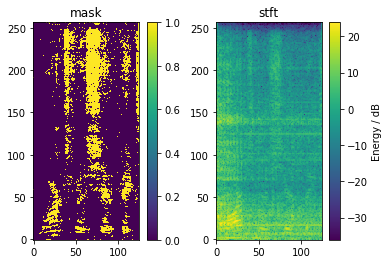

In [194]:
# loading the ground truth masks
fig, axes = plt.subplots(1,2)
axes[0].title.set_text('mask')
plot_mask(data_dict['ground_truth_mask'], ax=axes[0])
axes[1].title.set_text('stft')
plot_stft(data_dict['stft'], ax=axes[1])

In [195]:
# applying the mask is just elemenet wise multiplication 
def apply_mask(mask, tfs, i):
    return (mask == i)*tfs

In [199]:
# applaing the ground truth mask
src1_tfs = apply_mask(data_dict['ground_truth_mask'], data_dict['stft'], 0)
src2_tfs = apply_mask(data_dict['ground_truth_mask'], data_dict['stft'], 1)

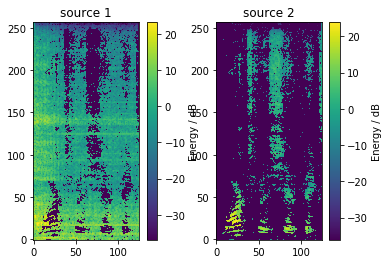

In [200]:
fig, axes = plt.subplots(1,2)
axes[0].title.set_text('source 1')
plot_stft(src1_tfs, ax=axes[0])
axes[1].title.set_text('source 2')
plot_stft(src2_tfs, ax=axes[1])

In [207]:
# source 1 reconstructed
src1 = istft(src1_tfs)
IPython.display.Audio(src1, rate=sr)

In [208]:
# source 1 original
IPython.display.Audio(data_dict['wavs'][0], rate=sr)

In [209]:
# source 2 reconstructed
src2 = istft(src2_tfs)
IPython.display.Audio(src2, rate=sr)

In [211]:
# source 2 original
IPython.display.Audio(data_dict['wavs'][1], rate=sr)

#### Pretty Good !!!

### 3. What is DC(Deep Clustering) and using it for SS or BSS(Blind Source Separation)

#### What are the steps of the DC algorithem for source seperation?
1. feed forword the absolute value of the stft, bin by bin, and create vector in the embedding space for each bin
2. cluster the vectors in the embedding space using K-Means, each bin's label will corespond to the cluster it's embedding vector will belong to

In [254]:
from spatial_two_mics.dnn.utils.model_logger import load_and_create_the_model
model_path = os.path.join(demo_cache, 'dc_model.pt')

In [255]:
# loading a pretrained model
model, _, _, _, args, _, _, _ = load_and_create_the_model(model_path)
# this is nessesary for avoiding gradient calculations
model.eval() 

DataParallel(
  (module): BLSTMEncoder(
    (rnn): LSTM(257, 1024, batch_first=True)
    (affine): Linear(in_features=1024, out_features=4112, bias=True)
  )
)

In [256]:
# some arguments about the model architecture settings
bidirectional = args.bidirectional
D = args.embedding_depth
n_layers = args.n_layers
bidirectional, D, n_layers

(False, 16, 1)

In [257]:
# feed the stft to the model:
mixture_tfs = data_dict['stft']
# pyTorch does not support complex Tensors, so use the complex norm:
X = torch.Tensor(np.abs(mixture_tfs))
# add batch dimention first, and move frequancy dimention last:
X = rearrange(X, '(b f) t -> b t f', b=1)
X.size()

torch.Size([1, 125, 257])

In [258]:
# doning the forward pass - what do we get?
Y = model(X)
Y.size()

torch.Size([1, 32125, 16])

#### How the forword pass work? What are the dimentions?

So the model goes by every time-frequancy bin of $X$,(basicly flattens X to 1 dim vector) and creates for it a- $D$ dimentional vector in the embedding space. because we are using an RNN, every output is dependent on the previous input, so the model takes into acount not only the current data point, but all of the previous ones(and the next ones if its bidirectional).

$$L=T\cdot F$$
$$model:\mathbb R^L\rightarrow \mathbb R^{L\times D}$$

lets check the math:

In [259]:
assert X.size()[1] * X.size()[2] == Y.size()[1]
assert Y.size()[2] == D

In [260]:
# appleing the KMeans clustering algorithem
kmeans = KMeans(n_clusters=2)
Y_temp = Y[0].detach().numpy()
pred_mask = kmeans.fit_predict(Y_temp)
pred_mask = pred_mask.reshape(X[0].size())
pred_mask.shape

(125, 257)

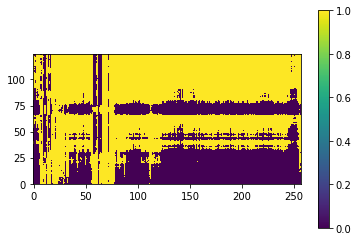

In [261]:
# showing the masks
plot_mask(pred_mask)

#### The Loss:
The loss of the model is calculated by the divergence of the predicted mask, and the given mask that the model is trained on.
lets calculate the loss in respect to the ground truth mask.
(more details in the paper)

In [262]:
# source 1
model_src1 = istft(apply_mask(pred_mask.T, mixture_tfs, 0))
IPython.display.Audio(model_src1, rate=sr)

In [263]:
# source 2
model_src1 = istft(apply_mask(pred_mask.T, mixture_tfs, 1))
IPython.display.Audio(model_src1, rate=sr)

### 4. Using MC(Multi-Channel) input for BSS without DL(Deep Learning) and computing masks using those methods for unsupervised training of a DC model

#### Why is multi-channel different from mono-channel?
So the main idea here is to train the model in an unsupervised way.
What we did for now is to create the masks from the ground truth.

When our signal comes from more then one channel(is recorded by microphones that are not in the exact same positions), we have more data that we can use in order to infer not only the spectral data of the sound, but also spatial data.

**for example:** if we have 2 mic's and 2 sources, we can use the phase differences between the 2 signals recorded by different mic's, and we would expect that if the sources are far enough from each other, the sound waves that come from one source will have a different phase shift in the 2 recordings. - this is what the original paper used.

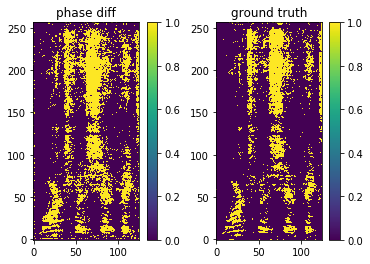

In [268]:
# in the preprocessing of the audio, the phase difference was calculated,
# and bins with the most similar phase differences are clustered together
pd_mask = data_dict['soft_labeled_mask']
gt_mask = data_dict['ground_truth_mask']
fig, axes = plt.subplots(1, 2)
axes[0].title.set_text('phase diff')
axes[1].title.set_text('ground truth')
# the colors are inverted, this is why pd_mask == 0:
plot_mask((pd_mask == 0), ax=axes[0])
plot_mask(gt_mask, ax=axes[1])

#### mentioning some non-DL methods for BSS:
doing BSS from multi-channel input is a hot thing this days, and a lot of interesting works are going on.

2 more examples are-
1. cACGMM is done by assuming some probability distribution of the sources, and maximizing the parameters to get the best seperation results. A paper using this method for training a DC model was published, but unfortunatly without code or the data set easily available

2. a python package called `pyroomacustics` that is built to simulate acustic environments for building and testing this type of algorithems has implementation of some of the popular ones

**NOTE:** some methods will better fit different types of seperations 

In [81]:
# demo 1 - the phase difference used in the experiment

In [269]:
# demo 2 - another method, proposed in a simmilar article (cACGMM)
from scipy import signal
from pb_bss.distribution import CACGMMTrainer, CBMMTrainer, CWMMTrainer
from pb_bss.permutation_alignment import DHTVPermutationAlignment, OraclePermutationAlignment
from pb_bss.evaluation import InputMetrics, OutputMetrics

def seperate_sources(audio_data, num_classes=2, num_channels=2, sample_rate=16000,
                     nperseg=128, nfft=512, iterations=40):
    """
    the multi-channel input signal
    num_classes - the number of classes to seperate
    sample_rate - the sample rate of the file
    nperseg - the time window size of the stft
    nfft - the number of frequancy bins in the stft
    iterations - the number of iterations to do
    @returns - a list of the seperated sources
    """
    # make stft
    f, t, stft_data = signal.stft(audio_data, nperseg=nperseg, nfft=nfft)
    
    # trainer + training + prediction:
    trainer = CACGMMTrainer()
    
    stft_data_mm = rearrange(stft_data, 'channel freq time -> freq time channel')
    
    model = trainer.fit(
        stft_data_mm,
        num_classes=num_classes,
        iterations=iterations,
    )
    
    affiliation = model.predict(stft_data_mm)
    
    affiliation = rearrange(affiliation, 'freq source time -> source freq time')
    
    # permutation alignment
    pa = DHTVPermutationAlignment.from_stft_size(nfft)
    affiliation_pa = pa(affiliation)
    
    ## just for testing
    f, axes = plt.subplots(num_classes, 1, figsize=(20, 10))
    for i in range(num_classes):
        plot_mask(affiliation_pa[i], ax=axes[i])
    ## 
    
    # use the mask to estimate the source signal
    seperated_sources_stft = []
    for i in range(num_classes):
        source = [affiliation_pa[i] * stft_data[c] for c in range(num_channels)] 
        seperated_sources_stft.append(source)
    seperated_sources_stft = np.array(seperated_sources_stft)
    
    # restore the estimated seperated sounds
    t, seperated_sources_audio = signal.istft(seperated_sources_stft, 
                                              nperseg=nperseg, nfft=nfft)
    
    # return the seperated signal
    return seperated_sources_audio
    

array([[[-2.10519224e+00, -2.51085124e+00, -1.48242932e-01, ...,
          1.45144331e-01,  1.78368491e-01,  8.85654219e-02],
        [-2.91683326e-02, -3.39242575e-02, -3.45817185e-02, ...,
         -2.36968211e-02, -2.21083324e-02, -2.93419003e-02]],

       [[-4.32270228e-02, -4.97550797e-02, -4.06910778e-02, ...,
         -7.65584495e-02,  2.09105594e-01, -8.85654219e-02],
        [-1.76517691e-03, -1.80560873e-03, -1.78879804e-03, ...,
         -6.25051040e-03, -1.07302624e-01,  2.93419003e-02]]])

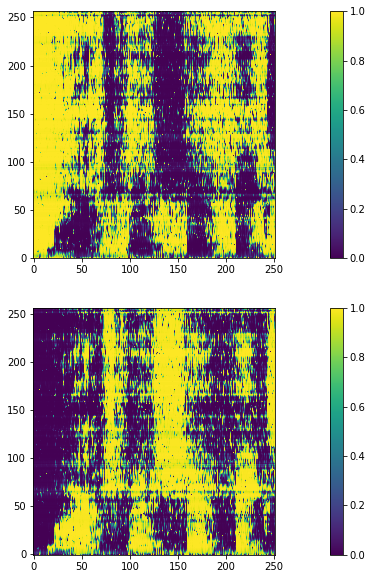

In [273]:
audio_data = np.array(data_dict['wavs'])
audio_data.shape
seperate_sources(audio_data)

In [86]:
# demo 3 - yet another demo, based on an interesting package, pyroomacustics